In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from tqdm.notebook import tqdm
from PIL import Image

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
os.listdir('/content/drive/MyDrive/1000images')

['0.0.Normal',
 '1.1.DR3',
 '10.0.Possible glaucoma',
 '1.0.DR2',
 '11.Severe hypertensive retinopathy',
 '0.2.Large optic cup',
 '10.1.Optic atrophy',
 '0.3.DR1',
 '0.1.Tessellated fundus',
 '2.0.BRVO',
 '19.Fundus neoplasm',
 '15.1.Bietti crystalline dystrophy',
 '18.Vitreous particles',
 '14.Congenital disc abnormality',
 '13.Dragged Disc',
 '15.0.Retinitis pigmentosa',
 '12.Disc swelling and elevation',
 '17.Myelinated nerve fiber',
 '16.Peripheral retinal degeneration and break',
 '28.Silicon oil in eye',
 '24.Chorioretinal atrophy-coloboma',
 '26.Fibrosis',
 '21.Yellow-white spots-flecks',
 '25.Preretinal hemorrhage',
 '22.Cotton-wool spots',
 '27.Laser Spots',
 '2.1.CRVO',
 '20.Massive hard exudates',
 '23.Vessel tortuosity',
 '3.RAO',
 '9.Pathological myopia',
 '7.ERM',
 '4.Rhegmatogenous RD',
 '5.0.CSCR',
 '6.Maculopathy',
 '29.1.Blur fundus with suspected PDR',
 '8.MH',
 '29.0.Blur fundus without PDR',
 '5.1.VKH disease']

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class custom_dataset(Dataset):
    def __init__(self,root_dir,transform=None):

        self.data=[]
        self.transform=transform

        for img_path in tqdm(glob.glob(root_dir+"/*/**")):
            class_name=img_path.split("/")[-2]
            self.data.append([img_path,class_name])

        self.class_map={}
        for index,item in enumerate(os.listdir(root_dir)):
             self.class_map[item]=index
        print(f"Total Classes:{len(self.class_map)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_path,class_name=self.data[idx]
        img=Image.open(img_path)
        class_id=self.class_map[class_name]
        class_id=torch.tensor(class_id)

        if self.transform:
            img=self.transform(img)

        return img,class_id

In [ ]:
root_dir=r'/content/drive/MyDrive/1000images (1)'

In [ ]:
def create_transforms(normalize=False,mean=[0,0,0],std=[1,1,1]):
    if normalize:
        my_transforms=transforms.Compose([
            transforms.Resize((224,224)),
#             transforms.ColorJitter(brightness=0.3,saturation=0.5,contrast=0.7,),
#             transforms.RandomRotation(degrees=33),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,std=std)
        ])

    else:
         my_transforms=transforms.Compose([
            transforms.Resize((512,512)),
#             transforms.ColorJitter(brightness=0.3,saturation=0.5,contrast=0.7,p=0.57),
#             transforms.RandomRotation(degrees=33),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()])


    return my_transforms

In [ ]:
BS=8
num_classes=39

In [ ]:
my_transforms=create_transforms(normalize=False)
dataset=custom_dataset(root_dir,my_transforms)
print(len(dataset))

train_set, val_set=torch.utils.data.random_split(dataset,[800,200],generator=torch.Generator().manual_seed(7))
train_loader=DataLoader(train_set,batch_size=BS,shuffle=True)
val_loader=DataLoader(val_set,batch_size=BS,shuffle=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Total Classes:40
1000


In [ ]:
def get_mean_std(loader):
    #var=E[x^2]-(E[x])^2
    channels_sum, channels_squared_sum,num_batches=0,0,0
    for data,_ in tqdm(loader):
        channels_sum+=torch.mean(data,dim=[0,2,3]) # we dont want to a singuar mean for al 3 channels (in case of RGB)
        channels_squared_sum+=torch.mean(data**2,dim=[0,2,3])
        num_batches+=1
    mean=channels_sum/num_batches
    std=(channels_squared_sum/num_batches-mean**2)**0.5

    return mean, std

In [ ]:
mean,std=get_mean_std(train_loader)
print(mean, std)

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.4621, 0.2672, 0.1061]) tensor([0.2384, 0.1514, 0.0813])


In [ ]:
#Since these are medical images (differenct from Imagenet data) I'll use the calculated mean, std
my_transforms=create_transforms(normalize=True,mean=mean,std = std)
dataset=custom_dataset(root_dir,my_transforms)
print(len(dataset))

train_set, val_set=torch.utils.data.random_split(dataset,[800,200],generator=torch.Generator().manual_seed(7))
train_loader=DataLoader(train_set,batch_size=BS,shuffle=True)
val_loader=DataLoader(val_set,batch_size=BS,shuffle=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Total Classes:40
1000


In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=8e9ea6d6fc86c7fc59f7de2c30be1766b3cbfb569b2f7faf4ab65ef86df2efdd
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
def create_eff_net(version='b7',trainable=False):
    eff_model = EfficientNet.from_name(f'efficientnet-{version}')

    for param in eff_model.parameters():
        param.requires_grad = trainable

    num_ftrs = eff_model._fc.in_features

    eff_model._fc = nn.Sequential(
    nn.Linear(num_ftrs,1024),
    nn.ReLU(),
    nn.Dropout(p=0.37),
    nn.Linear(1024,num_classes)
    )

    eff_model.to(device)

    return eff_model

In [ ]:
EPOCHS=140
LR=1e-3

In [ ]:
def train_model(model):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9,verbose=True)

    for epoch in range(EPOCHS):
        losses=[]
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        loop=tqdm(enumerate(train_loader),total=len(train_loader))
        for batch_idx,(data,targets) in loop:
            data=data.to(device)
            targets=targets.to(device)

            #forward
            scores=model(data)
            loss=criterion(scores,targets)

            losses.append(loss.item())

            #backward
            optimizer.zero_grad()
            loss.backward()

            #gradient descent/adam step
            optimizer.step()
        mean_loss=sum(losses)/len(losses)
        scheduler.step()

        print(f"Loss at Epoch {epoch+1}:\t{mean_loss:.5f}\n")

In [ ]:
eff_model=create_eff_net(version='b7',trainable=True)

In [ ]:
train_model(eff_model)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Loss at Epoch 1:	3.61930

Epoch 2/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0000e-04.
Loss at Epoch 2:	3.43398

Epoch 3/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0000e-04.
Loss at Epoch 3:	3.47772

Epoch 4/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1000e-04.
Loss at Epoch 4:	3.46373

Epoch 5/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1000e-04.
Loss at Epoch 5:	3.43167

Epoch 6/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2900e-04.
Loss at Epoch 6:	3.44584

Epoch 7/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2900e-04.
Loss at Epoch 7:	3.40133

Epoch 8/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5610e-04.
Loss at Epoch 8:	3.35319

Epoch 9/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5610e-04.
Loss at Epoch 9:	3.34435

Epoch 10/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9049e-04.
Loss at Epoch 10:	3.25783

Epoch 11/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9049e-04.
Loss at Epoch 11:	3.16442

Epoch 12/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3144e-04.
Loss at Epoch 12:	3.12395

Epoch 13/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3144e-04.
Loss at Epoch 13:	3.06659

Epoch 14/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7830e-04.
Loss at Epoch 14:	3.05101

Epoch 15/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7830e-04.
Loss at Epoch 15:	3.03628

Epoch 16/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3047e-04.
Loss at Epoch 16:	3.05565

Epoch 17/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3047e-04.
Loss at Epoch 17:	2.98381

Epoch 18/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8742e-04.
Loss at Epoch 18:	3.01779

Epoch 19/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8742e-04.
Loss at Epoch 19:	2.96430

Epoch 20/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4868e-04.
Loss at Epoch 20:	2.94678

Epoch 21/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4868e-04.
Loss at Epoch 21:	2.90656

Epoch 22/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1381e-04.
Loss at Epoch 22:	2.89972

Epoch 23/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1381e-04.
Loss at Epoch 23:	2.81460

Epoch 24/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8243e-04.
Loss at Epoch 24:	2.81563

Epoch 25/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8243e-04.
Loss at Epoch 25:	2.82928

Epoch 26/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5419e-04.
Loss at Epoch 26:	2.72734

Epoch 27/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5419e-04.
Loss at Epoch 27:	2.74757

Epoch 28/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2877e-04.
Loss at Epoch 28:	2.75099

Epoch 29/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2877e-04.
Loss at Epoch 29:	2.67742

Epoch 30/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0589e-04.
Loss at Epoch 30:	2.65306

Epoch 31/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0589e-04.
Loss at Epoch 31:	2.64293

Epoch 32/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8530e-04.
Loss at Epoch 32:	2.61107

Epoch 33/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8530e-04.
Loss at Epoch 33:	2.57864

Epoch 34/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6677e-04.
Loss at Epoch 34:	2.55667

Epoch 35/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6677e-04.
Loss at Epoch 35:	2.52740

Epoch 36/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5009e-04.
Loss at Epoch 36:	2.50967

Epoch 37/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5009e-04.
Loss at Epoch 37:	2.48033

Epoch 38/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3509e-04.
Loss at Epoch 38:	2.43265

Epoch 39/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3509e-04.
Loss at Epoch 39:	2.37624

Epoch 40/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2158e-04.
Loss at Epoch 40:	2.42949

Epoch 41/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2158e-04.
Loss at Epoch 41:	2.32642

Epoch 42/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0942e-04.
Loss at Epoch 42:	2.32814

Epoch 43/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0942e-04.
Loss at Epoch 43:	2.23233

Epoch 44/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8477e-05.
Loss at Epoch 44:	2.23093

Epoch 45/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8477e-05.
Loss at Epoch 45:	2.22864

Epoch 46/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8629e-05.
Loss at Epoch 46:	2.14955

Epoch 47/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8629e-05.
Loss at Epoch 47:	2.20305

Epoch 48/140:


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9766e-05.
Loss at Epoch 48:	2.09312

Epoch 49/140:


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def check_accuracy(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [ ]:
print("Training accuracy:",end='\t')
check_accuracy(train_loader, eff_model)
print("Validation accuracy:",end='\t')
check_accuracy(val_loader, eff_model)

Training accuracy:	

  0%|          | 0/100 [00:00<?, ?it/s]

Got 293 / 800 with accuracy 36.62
Validation accuracy:	

  0%|          | 0/25 [00:00<?, ?it/s]

Got 55 / 200 with accuracy 27.50


<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  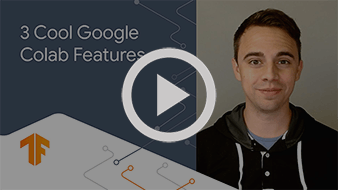
  </a>
</center>

<div class="markdown-google-sans">
  <h1>What is Colab?</h1>
</div>

Colab, or ‘Colaboratory’, allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a <strong>student</strong>, a <strong>data scientist</strong> or an <strong>AI researcher</strong>, Colab can make your work easier. Watch <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Introduction to Colab</a> to find out more, or just get started below!

<div class="markdown-google-sans">

## <strong>Getting started</strong>
</div>

The document that you are reading is not a static web page, but an interactive environment called a <strong>Colab notebook</strong> that lets you write and execute code.

For example, here is a <strong>code cell</strong> with a short Python script that computes a value, stores it in a variable and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut 'Command/Ctrl+Enter'. To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine <strong>executable code</strong> and <strong>rich text</strong> in a single document, along with <strong>images</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To find out more, see <a href="/notebooks/basic_features_overview.ipynb">Overview of Colab</a>. To create a new Colab notebook you can use the File menu above, or use the following link: <a href="http://colab.research.google.com#create=true">Create a new Colab notebook</a>.

Colab notebooks are Jupyter notebooks that are hosted by Colab. To find out more about the Jupyter project, see <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyse and visualise data. The code cell below uses <strong>numpy</strong> to generate some random data, and uses <strong>matplotlib</strong> to visualise it. To edit the code, just click the cell and start editing.

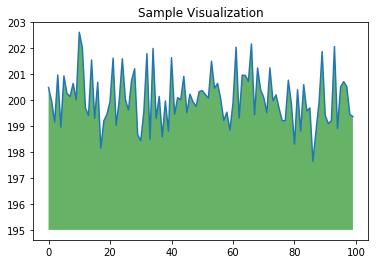

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from GitHub and many other sources. To find out more about importing data, and how Colab can be used for data science, see the links below under <a href="#working-with-data">Working with data</a>.

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">a few lines of code</a>. Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including <a href="#using-accelerated-hardware">GPUs and TPUs</a>, regardless of the power of your machine. All you need is a browser.

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the <a href="#machine-learning-examples">machine learning examples</a> below.

<div class="markdown-google-sans">

## More resources

### Working with notebooks in Colab

</div>

- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with data
</div>

- [Loading data: Drive, Sheets and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualising data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine learning crash course

<div>

These are a few of the notebooks from Google's online machine learning course. See the <a href="https://developers.google.com/machine-learning/crash-course/">full course website</a> for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using accelerated hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">NeMo voice swap</a>: Use Nvidia NeMo conversational AI toolkit to swap a voice in an audio fragment with a computer-generated one.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Retraining an Image Classifier</a>: Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Text Classification</a>: Classify IMDB film reviews as either <em>positive</em> or <em>negative</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Style Transfer</a>: Use deep learning to transfer style between images.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: Use a machine-learning model to answer questions from the SQuAD dataset.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Video Interpolation</a>: Predict what happened in a video between the first and the last frame.
